In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])

In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_b.shape

(60, 2)

In [5]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_b['Sales'].sum()

70016882

In [7]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

,ds,y
0,2019-01-01,494357
1,2019-02-01,837207
2,2019-03-01,1278271
3,2019-04-01,675985
4,2019-05-01,757687


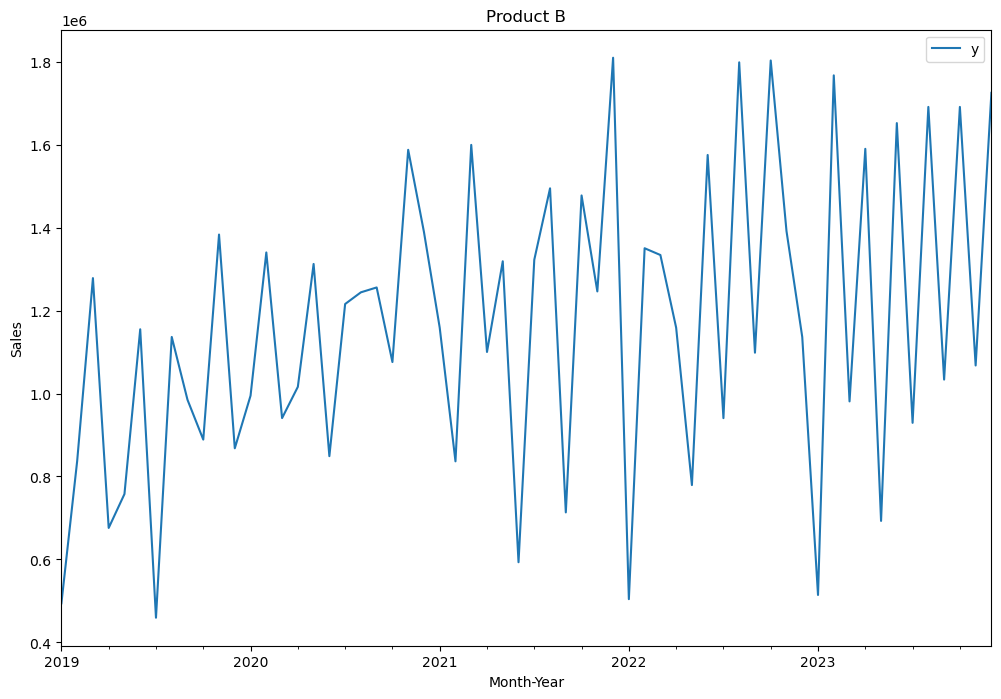

In [8]:
ax = sales_b.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.show()

In [9]:
train= sales_b[:48]
test=sales_b[48:]

# Hyperparameter Tuning

In [312]:
changepoint_prior_scale_range = [0.001,0.01, 0.1, 0.1008, 0.2006, 0.3004, 0.4002, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 2.008, 4.006, 6.004, 8.002, 10.0]

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:32:58 - cmdstanpy - INFO - Chain [1] start processing
15:32:58 - cmdstanpy - INFO - Chain [1] done processing
15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:00 - cmdstanpy - INFO - Chain [1] done processing
15:33:02 - cmdstanpy - INFO - Chain [1] start processing
15:33:18 - cmdstanpy - INFO - Chain [1] done processing
15:33:20 - cmdstanpy - INFO - Chain [1] start processing
15:33:20 - cmdstanpy - INFO - Chain [1] done processing
15:33:22 - cmdstanpy - INFO - Chain [1] start processing
15:33:22 - cmdstanpy - INFO - Chain [1] done processing
15:33:24 - cmdstanpy - INFO - Chain [1] start processing
15:33:24 - cmdstanpy - INFO - Chain [1] done processing
15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing
15:33:29 - cmdstanpy - INFO - Chain [1] start processing
15:33:29 - cmdstanpy - INFO - Chain [1] done processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:32 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                     0.001                    0.010  413965.200491
1                     0.001                    0.100  391725.139416
2                     0.001                    1.000  365627.058410
3                     0.001                    2.008  365405.792712
4                     0.001                    4.006  361833.791085
..                      ...                      ...            ...
59                    0.500                    2.008  336286.342390
60                    0.500                    4.006  336577.733785
61                    0.500                    6.004  337491.788061
62                    0.500                    8.002  335152.189158
63                    0.500                   10.000  335151.484717

[64 rows x 3 columns]


In [313]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,rmse
63,0.5000,10.000,335151.484717
62,0.5000,8.002,335152.189158
59,0.5000,2.008,336286.342390
55,0.4002,10.000,336539.596176
60,0.5000,4.006,336577.733785
...,...,...,...
16,0.1000,0.010,412815.516979
24,0.1008,0.010,412820.105157
40,0.3004,0.010,412985.924453
32,0.2006,0.010,413201.560854


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.5000	, seasonality_prior_scale=10.000,seasonality_mode='multiplicative', interval_width=0.95)

In [11]:
model.fit(train)

17:17:47 - cmdstanpy - INFO - Chain [1] start processing
17:17:47 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [13]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [14]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [15]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,9.406217e+05,5.404433e+05,1.309464e+06
49,2023-02-01,1.443781e+06,1.074785e+06,1.795519e+06
50,2023-03-01,1.704477e+06,1.341254e+06,2.090561e+06
51,2023-04-01,1.037395e+06,6.830075e+05,1.395728e+06
52,2023-05-01,8.310647e+05,4.557060e+05,1.248739e+06
53,2023-06-01,1.766019e+06,1.416129e+06,2.138789e+06
54,2023-07-01,7.833303e+05,4.048029e+05,1.161782e+06
55,2023-08-01,1.881185e+06,1.477311e+06,2.258445e+06
56,2023-09-01,1.221652e+06,8.276573e+05,1.595155e+06
57,2023-10-01,1.689113e+06,1.337035e+06,2.056255e+06


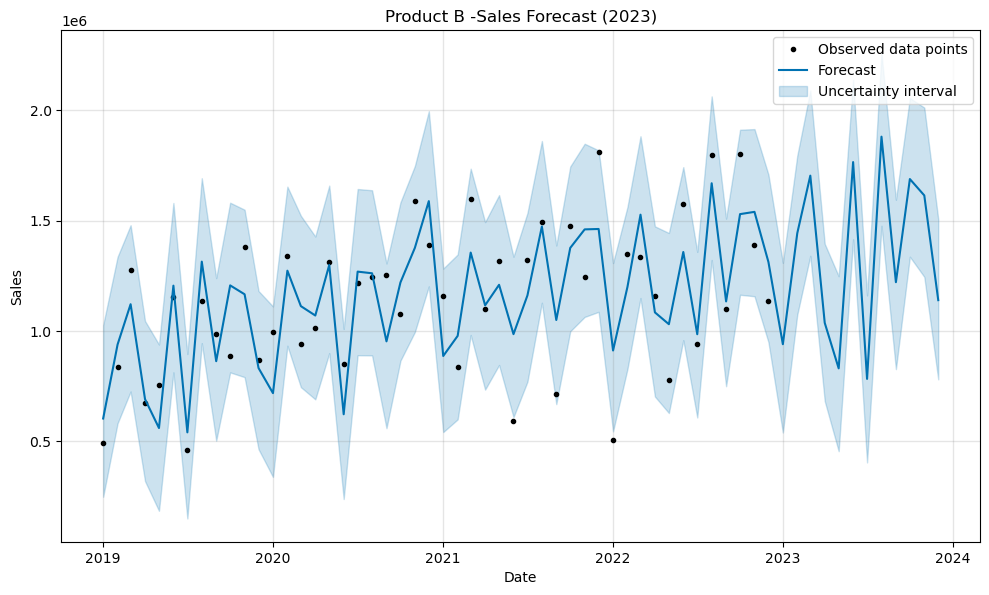

In [16]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

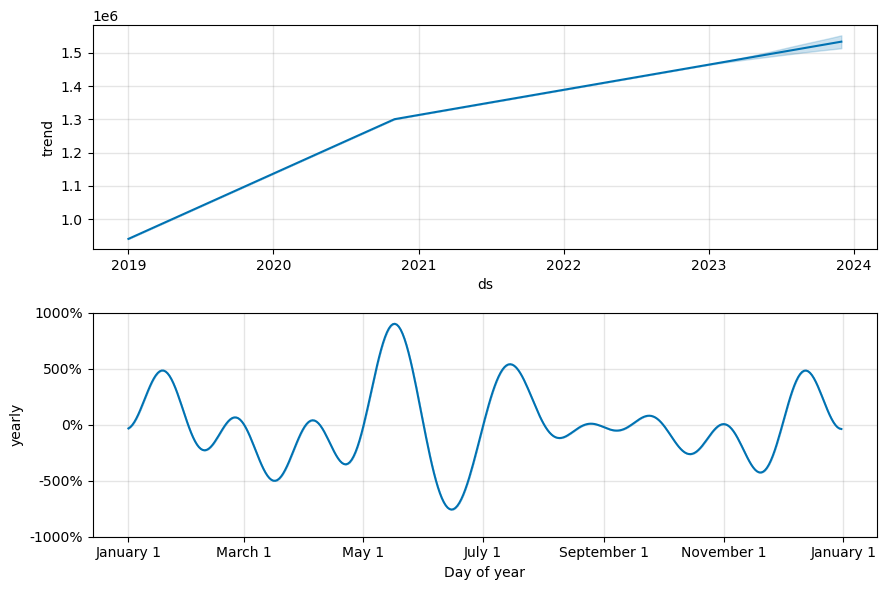

In [17]:
fig2 = model.plot_components(forecast)

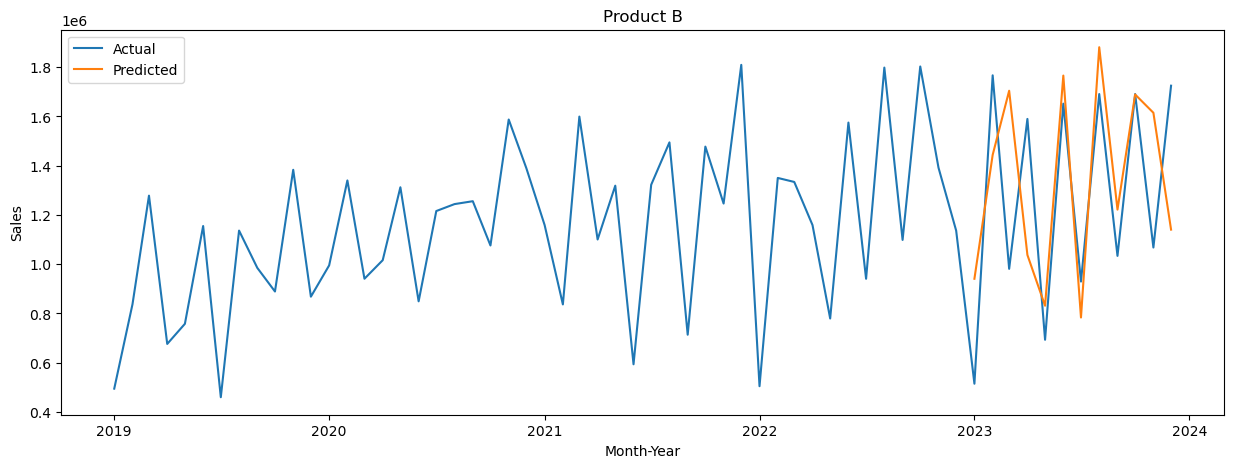

In [18]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [19]:
#model evaluation

In [20]:
pred=forecasted_df['yhat']
test_df=test['y']

In [21]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 327983.789
MAPE - FB PROPHET: 0.306
MSE - FB PROPHET: 156766522778.841
RMSE - FB PROPHET: 395937.524


In [326]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [327]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [328]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,4.435197e+11,665972.717503,665972.717503,1.320633,1.320633,0.795410,0.0
1,62 days,4.102446e+10,202544.957788,202544.957788,0.150007,0.150007,0.162170,1.0
2,90 days,5.442840e+10,233298.941483,233298.941483,0.174894,0.174894,0.160830,1.0
3,121 days,4.260904e+09,65275.602026,65275.602026,0.056333,0.056333,0.057966,1.0
4,151 days,2.192522e+11,468243.746459,468243.746459,0.600838,0.600838,0.462034,0.0
5,182 days,1.306246e+11,361420.194973,361420.194973,0.229458,0.229458,0.259195,0.0
6,212 days,2.143953e+10,146422.427492,146422.427492,0.155661,0.155661,0.144421,1.0
7,243 days,7.483566e+10,273561.074600,273561.074600,0.152110,0.152110,0.164631,1.0
8,274 days,1.405000e+10,118532.702890,118532.702890,0.107910,0.107910,0.102386,1.0
9,304 days,2.100928e+11,458358.859903,458358.859903,0.254236,0.254236,0.291261,0.0


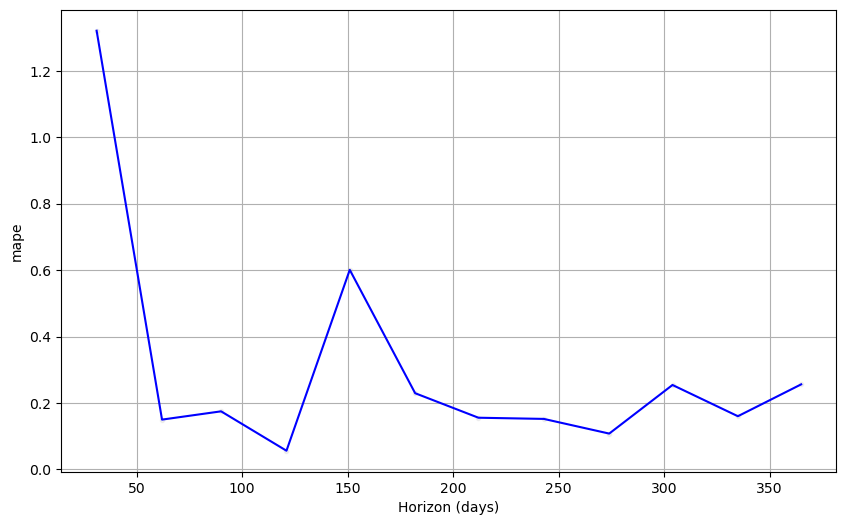

In [329]:
fig = plot_cross_validation_metric(df_cv, metric='mape')